In [6]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import xarray as xr
import atlite
from atlite.gis import shape_availability, ExclusionContainer

from shapely.geometry import Point
from shapely.ops import unary_union
import numpy as np
import rasterio
import shapely

from dask.distributed import Client, LocalCluster

nprocesses = 10
cluster = LocalCluster(n_workers=nprocesses, threads_per_worker=2)
client = Client(cluster, asynchronous=True)

resource={}
resource["dask_kwargs"] = {"scheduler": client}

import PySAM.Pvwattsv8 as pv

/home/pklein/anaconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41687 instead
  warnings.warn(


# Atlite Solar PV Potential for REDZ 2017 to 2019

### Load data

/home/pklein/anaconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<Axes: >

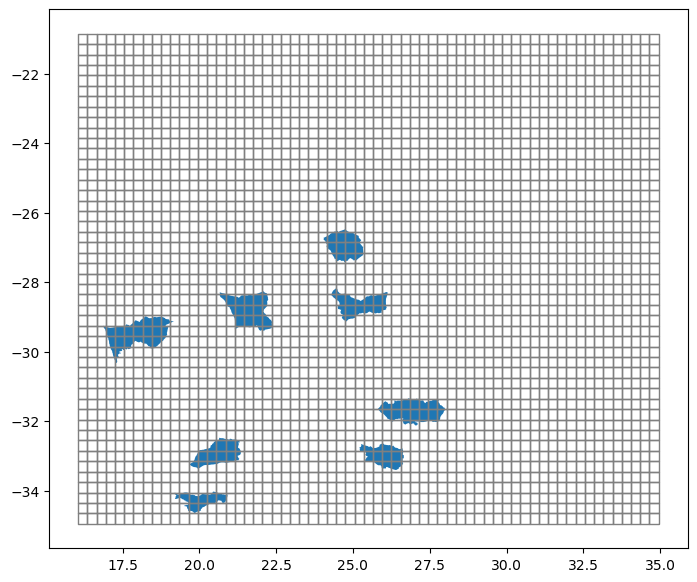

In [7]:
# Load REDZs regions
shapefile_1 = gpd.read_file('../data/bundle/REDZ_DEA_Unpublished_Draft_2015/REDZ_DEA_Unpublished_Draft_2015.shp')
#shapefile_2 = gpd.read_file('../data/bundle/Phase2_REDZs/PHASE 2_REDZs.shp')

combined_shapefile = shapefile_1.to_crs('EPSG:4326')
#shapefile_2_transformed = shapefile_2.to_crs('EPSG:4326')

#combined_shapefile = gpd.GeoDataFrame(pd.concat([shapefile_1_transformed, shapefile_2_transformed], ignore_index=True))
#combined_shapefile = combined_shapefile.set_index('Name')

# Load cutout for entire RSA region
cutout = atlite.Cutout(
    path="../cutouts/RSA-2017_20-era5.nc",
    chunks={"time": 100},
)

cutout.data = cutout.data.sel(time='2017')

# Visualise REDZs and RSA cutout
plt.rc("figure", figsize=[10, 7])
fig, ax = plt.subplots()
combined_shapefile.plot(ax=ax)
cutout.grid.plot(ax=ax, edgecolor="grey", color="None")

### Exclude cells within REDZs which are inelligible

In [8]:
landuse = '../data/bundle/landuse_without_protected_conservation.tiff'
excluder = ExclusionContainer()
excluder.add_raster(landuse)

availability_matrix = cutout.availabilitymatrix(combined_shapefile,excluder=excluder,nprocesses=3)    


/home/pklein/anaconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/geopandas/geoseries.py:207: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
/home/pklein/anaconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/geopandas/geoseries.py:207: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
/home/pklein/anaconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/geopandas/geoseries.py:207: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
Compute availability matrix: 100%|

In [9]:
# Visualise available land
fg = availability_matrix.plot(row="Name", col_wrap=3, cmap="Greens")
fg.set_titles("{value}")
for i, c in enumerate(combined_shapefile.index):
    combined_shapefile.loc[[c]].plot(ax=fg.axs.flatten()[i], edgecolor="k", color="None")

ValueError: Only 1d and 2d plots are supported for facets in xarray. See the package `Seaborn` for more options.

In [12]:
# # Calculate capacities per REDZs
# cap_per_sqkm = 1.7 # value from pypsa-eur
# area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
# area = xr.DataArray(area, dims=("spatial"))

# capacity_matrix = availability_matrix.stack(spatial=["y", "x"]) * area * cap_per_sqkm
# # Set available land to 1
# ones_matrix = np.ones_like(capacity_matrix)

pv_sat = cutout.pv(    
    panel="CSi",
    #matrix=ones_matrix,
    shapes=combined_shapefile,
    tracking="horizontal",
    per_unit=True, 
    orientation={"slope": 0.0, "azimuth": 0},
    **resource,
)

pv_ft = cutout.pv(    
    panel="CSi",
    #matrix=ones_matrix,
    shapes=combined_shapefile,
    tracking=None,
    per_unit=True, 
    orientation="latitude_optimal", # or {"slope": 0.0, "azimuth": 0},
    **resource,
)

ValueError: dimension spatial on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single array chunk along this dimension, i.e., ``.chunk(dict(spatial=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [11]:
pv_sat.sel(Name='Kimberley Solar').values.mean()

NameError: name 'pv_sat' is not defined

In [ ]:
# fig, axes = plt.subplots(nrows=11, ncols=1, figsize=(10, 40))

# for idx, ax in zip(combined_shapefile.index, axes):
#     data_1 = pv_sat.sel(Name=idx).to_pandas()
#     data_1.plot(ax=ax,color="r",label='Single Axis')

#     data_2 = pv_ft.sel(Name=idx).to_pandas()
#     data_2.plot(ax=ax,color="b",label='Fixed Tilt')


#     ax.set_ylabel("p.u.")
#     ax.set_title(f"REDZs: {idx}")
#     ax.legend()

# plt.tight_layout()
# plt.show()



# PySAM


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
from shapely.geometry import Point
from dask import delayed, compute


def extract_solar(cutout, cell):
    """
    
    """
    pv_inputs ={
		"system_capacity" : 1*1.2, #System size (DC nameplate) [kW]
		"module_type" : 1, # Module type [0/1/2]. Standard,Premium,Thin film
		"dc_ac_ratio" : 1.2,
		"bifaciality" : 0, # Module bifaciality factor [0 or ~0.65]
		"array_type" : 2, # Array type [0/1/2/3/4] fixed open rack,fixed roof mount,1-axis tracking,1-axis backtracking,2-axis tracking
		"azimuth" : 0, # Azimuth angle [deg]
		"gcr" : 0.3, # Ground coverage ratio [0..1]
		"soiling" : [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
		"losses" : 7, # Other DC losses [%]
		"en_snowloss" : 0, # Enable snow loss model [0/1]
		"inv_eff" : 95, # Inverter efficiency at rated power [%]
		"batt_simple_enable" : 0,# Enable Battery [0/1]
        'tilt': 0, #Tilt angle [deg]
	}
    selected_data = cutout.data.sel(x=cutout.grid.loc[cell,'x'], 
                                    y=cutout.grid.loc[cell,'y'], 
                                    method='nearest')
    dn = selected_data['influx_direct'].values.tolist()
    dh = selected_data['influx_diffuse'].values.tolist()
    gh = (selected_data['influx_direct'].values+selected_data['influx_diffuse'].values).tolist()
    tdry = (selected_data['temperature'].values-273.15).tolist()
    elev = (selected_data['height'].values).tolist()

    model = pv.new()
    for k, v in pv_inputs.items():
        if k != 'number_inputs':
            setattr(model.SystemDesign, k, v)
    model.AdjustmentFactors.constant = 0

    dates = pd.date_range('2017-01-01 00:00', '2017-12-31 23:00', freq='H')
    wspd = [0]*len(dates)
    year = list(dates.year)
    month = list(dates.month)
    day = list(dates.day)
    hour = list(dates.hour)
    minute = list(dates.minute)

    model.SolarResource.assign(
        {
            'solar_resource_data':{
                'dn':dn,
                'df':dh,
                'tdry':tdry,
                'wspd':wspd,
                'lat':cutout.grid.loc[cell,'y'],
                'lon':cutout.grid.loc[cell,'x'],
                'tz':2,
                'elev':elev,
                'year':year,
                'month':month,
                'day':day,
                'hour':hour,
                'minute':minute,
                'albedo':0.2,
                "use_wf_albedo":0,
                }
        }
    )
    model.execute()
    ac_output = model.Outputs.ac
 
    return np.array(ac_output)

def process_geometry(cutout, geometry, geometry_name):
    """
    
    """
    # Generate time range for the year
    times = pd.date_range(start='2017-01-01', end='2017-12-31 23:00', freq='H')
    gdf = gpd.GeoDataFrame(cutout.grid, 
                           geometry=[Point(xy) for xy in zip(cutout.grid.x, cutout.grid.y)])

    # Find points within the geometry
    within_geometry = gdf[gdf.geometry.within(geometry)]
    latitudes = np.array(sorted(set(within_geometry['y'])))
    longitudes = np.array(sorted(set(within_geometry['x']))) 

    #Save results in an xarray
    ac_annual_output = xr.DataArray(
        0, 
        coords=[times, latitudes, longitudes],
        dims=["time", "latitude", "longitude"]
    )

    for lat in latitudes:
        for long in longitudes:
            matching_cells = within_geometry.index[(within_geometry.x == long) & (within_geometry.y == lat)]
            if len(matching_cells) > 0:
                cell = matching_cells[0]
                ac_output = extract_solar(cutout, cell)  # Direct call
                ac_annual_output.loc[:, lat, long] = ac_output
    return geometry_name, ac_annual_output


def process_shapefile(cutout, shapefile_path,shapefile_key):
    """
    Process a single shapefile to generate hourly unitised solar profiles for each 
    geometry defined in the shapefile.

    This function reads a shapefile, applies land use exclusions using atlite, and then 
    iterates over each geometry within the shapefile. For each geometry, it extracts solar 
    data based on the geographic area defined by that geometry and compiles the results.

    
    """
    # Read the shapefile and convert its coordinate reference system to EPSG:4326 for latitude
    # and longitude calculations.
    shape_data = gpd.read_file(shapefile_path).to_crs('EPSG:4326')

    results = {}

    has_name = 'Name' in shape_data.columns
    has_corridor = 'Corridor' in shape_data.columns

    # Iterate over each geometry in the shapefile.
    for i, row in shape_data.iterrows():
        if has_name and pd.notnull(row['Name']) and row['Name'] != '':
            geometry_name = f"{shapefile_key}_{row['Name']}"
        elif has_corridor and pd.notnull(row['Corridor']) and row['Corridor'] != '':
            geometry_name = f"{shapefile_key}_{row['Corridor']}"
        else:
            geometry_name = f"{shapefile_key}_{i}"

        # Process the geometry to extract solar data and add the results to the dictionary.
        geometry_name, ac_annual_output  = process_geometry(cutout, 
                                                            row.geometry,
                                                            geometry_name)
        results[geometry_name] = ac_annual_output
    return results

def process_all_shapefiles(cutout, shapefile_dict):
    """
    Process multiple shape files to generate hourly unitised solar profiles for all 
    regions within the shape files.

    Parameters:
    - cutout: atlite cutout containing the ERA 5 meteorological data for the RSA region.
    - shapefile_dict: dictionary containing the shapefile keys and path to the shapefile. 

    Returns:
    - all_results: dictionary containing the shapefile key and the hourly unitised solar profiles

    """
    all_results = {}
    for shapefile_key, shapefile_path in shapefile_dict.items():
        shapefile_results = process_shapefile(cutout, shapefile_path, shapefile_key)
        all_results[shapefile_key] = shapefile_results
     
    return all_results

In [ ]:
# shapefile_dict = {
#     'redz_1': '../data/bundle/Phase1_REDZs/REDZs.shp',
#     'redz_2': '../data/bundle/Phase2_REDZs/PHASE 2_REDZs.shp',
#     #'power_corridor': '../data/bundle/Power_corridors/Power_corridors.shp',
#     #'11_supply': '../data/bundle/supply_regions/11-supply.shp',
#     #'30_supply': '../data/bundle/supply_regions/30-supply.shp'
# }

# all_geometry_results = process_all_shapefiles(cutout, shapefile_dict)

# for shapefile_key, geometries in all_geometry_results.items():
#     for geometry_name, data_array in geometries.items():
#         filename = f"{geometry_name}.nc"
#         if isinstance(data_array, xr.DataArray):
#             data_array.to_netcdf(filename)
#         else:
#             print(f"Unexpected format for {geometry_name}: {type(data_array)}")


In [ ]:
# import pandas as pd
# import geopandas as gpd
# import numpy as np
# import xarray as xr
# from shapely.geometry import Point
# from dask import delayed, compute


# def extract_solar(cutout, cell):
#     """
    
#     """

#     pv_inputs ={
# 		"system_capacity" : 1*1.2, #System size (DC nameplate) [kW]
# 		"module_type" : 1, # Module type [0/1/2]. Standard,Premium,Thin film
# 		"dc_ac_ratio" : 1.2,
# 		"bifaciality" : 0, # Module bifaciality factor [0 or ~0.65]
# 		"array_type" : 2, # Array type [0/1/2/3/4] fixed open rack,fixed roof mount,1-axis tracking,1-axis backtracking,2-axis tracking
# 		"azimuth" : 0, # Azimuth angle [deg]
# 		"gcr" : 0.3, # Ground coverage ratio [0..1]
# 		"soiling" : [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
# 		"losses" : 7, # Other DC losses [%]
# 		"en_snowloss" : 0, # Enable snow loss model [0/1]
# 		"inv_eff" : 95, # Inverter efficiency at rated power [%]
# 		"batt_simple_enable" : 0,# Enable Battery [0/1]
#         'tilt': 0, #Tilt angle [deg]
# 	}
#     selected_data = cutout.data.sel(x=cutout.grid.loc[cell,'x'], 
#                                     y=cutout.grid.loc[cell,'y'], 
#                                     method='nearest')
#     dn = selected_data['influx_direct'].values.tolist()
#     dh = selected_data['influx_diffuse'].values.tolist()
#     tdry = (selected_data['temperature'].values-273.15).tolist()
#     elev = (selected_data['height'].values).tolist()

#     model = pv.new()
#     for k, v in pv_inputs.items():
#         if k != 'number_inputs':
#             setattr(model.SystemDesign, k, v)
#     model.AdjustmentFactors.constant = 0

#     dates = pd.date_range('2017-01-01 00:00', '2017-12-31 23:00', freq='H')
#     wspd = [0]*len(dates)
#     year = list(dates.year)
#     month = list(dates.month)
#     day = list(dates.day)
#     hour = list(dates.hour)
#     minute = list(dates.minute)

#     model.SolarResource.assign(
#         {
#             'solar_resource_data':{
#                 'dn':dn,
#                 'df':dh,
#                 'tdry':tdry,
#                 'wspd':wspd,
#                 'lat':cutout.grid.loc[cell,'y'],
#                 'lon':cutout.grid.loc[cell,'x'],
#                 'tz':2,
#                 'elev':elev,#100,
#                 'year':year,
#                 'month':month,
#                 'day':day,
#                 'hour':hour,
#                 'minute':minute,
#                 'albedo':0.2,
#                 "use_wf_albedo":0,
#                 }
#         }
#     )
#     model.execute()
#     ac_output = model.Outputs.ac
#     # availability = availability.sel(x=cutout.grid.loc[cell,'x'],
#     #                                 y=cutout.grid.loc[cell,'y'],
#     #                                 method='nearest').values
#     return ac_output #np.array(ac_output)

# def process_geometry(cutout, geometry, geometry_name):
#     """
    
#     """
#     # Generate time range for the year
#     times = pd.date_range(start='2017-01-01', end='2017-12-31 23:00', freq='H')
#     gdf = gpd.GeoDataFrame(cutout.grid, 
#                            geometry=[Point(xy) for xy in zip(cutout.grid.x, cutout.grid.y)])

#     # Find points within the geometry
#     within_geometry = gdf[gdf.geometry.within(geometry)]
#     latitudes = np.array(sorted(set(within_geometry['y'])))
#     longitudes = np.array(sorted(set(within_geometry['x']))) 
#     print(f"Processing {len(latitudes) * len(longitudes)} lat-long pairs")

#     #Save results in an xarray
#     ac_annual_output = xr.DataArray(
#         0, 
#         coords=[times, latitudes, longitudes],
#         dims=["time", "latitude", "longitude"]
#     )

#     delayed_results = []
#     for lat in latitudes:
#             for long in longitudes:
#                 matching_cells = within_geometry.index[(within_geometry.x == long) & (within_geometry.y == lat)]
#                 if len(matching_cells) > 0:
#                     cell = matching_cells[0]
#                     ac_output = delayed(extract_solar)(cutout, cell)
#                     delayed_results.append(ac_output)

#     computed_results = compute(*delayed_results)
#     print(f"Total number of results in computed_results: {len(computed_results)}")

#     # print('computed_results')
#     # print(len(computed_results))
#     # Assign computed results to the DataArray
#     i = 0
#     for lat in latitudes:
#         for long in longitudes:
#             if ((within_geometry.x == long) & (within_geometry.y == lat)).any():
#                 ac_annual_output.loc[:, lat, long] = computed_results[i]
#                 i += 1
#     return geometry_name, delayed_results

# def process_shapefile(cutout, shapefile_path,shapefile_key):
#     """
#     Process a single shapefile to generate hourly unitised solar profiles for each 
#     geometry defined in the shapefile.

#     This function reads a shapefile, applies land use exclusions using atlite, and then 
#     iterates over each geometry within the shapefile. For each geometry, it extracts solar 
#     data based on the geographic area defined by that geometry and compiles the results.

    
#     """
#     # Read the shapefile and convert its coordinate reference system to EPSG:4326 for latitude
#     # and longitude calculations.
#     shape_data = gpd.read_file(shapefile_path).to_crs('EPSG:4326')
    
#     # Prepare the exclusion raster based on land use data.
#     # landuse = '../data/bundle/landuse_without_protected_conservation.tiff'
#     # excluder = ExclusionContainer()
#     # excluder.add_raster(landuse)

#     # Create an availability matrix that considers land use exclusions using atlite.
#     # availability_matrix = cutout.availabilitymatrix(shape_data,
#     #                                                 excluder=excluder,
#     #                                                 #nprocesses=4,
#     #                                                 )    
#     results = {}
#     delayed_results = []

#     has_name = 'Name' in shape_data.columns
#     has_corridor = 'Corridor' in shape_data.columns

#     # Iterate over each geometry in the shapefile.
#     for i, row in shape_data.iterrows():
#         if has_name and pd.notnull(row['Name']) and row['Name'] != '':
#             geometry_name = f"{shapefile_key}_{row['Name']}"
#             #availability = availability_matrix.sel(dim_0=i)
#         elif has_corridor and pd.notnull(row['Corridor']) and row['Corridor'] != '':
#             geometry_name = f"{shapefile_key}_{row['Corridor']}"
#             #availability = availability_matrix.sel(dim_0=i)
#         else:
#             geometry_name = f"{shapefile_key}_{i}"

#         # Process the geometry to extract solar data and add the results to the dictionary.
#         geometry_name, delayed_results_geometry = process_geometry(cutout, 
#                                                                 row.geometry,
#                                                                 geometry_name)
#         delayed_results.extend(delayed_results_geometry)     
#         results[geometry_name] = None 
#     return results, delayed_results

# def process_all_shapefiles(cutout, shapefile_dict):
#     """
#     Process multiple shape files to generate hourly unitised solar profiles for all 
#     regions within the shape files.

#     Parameters:
#     - cutout: atlite cutout containing the ERA 5 meteorological data for the RSA region.
#     - shapefile_dict: dictionary containing the shapefile keys and path to the shapefile. 

#     Returns:
#     - all_results: dictionary containing the shapefile key and the hourly unitised solar profiles

#     """
#     all_results = {}
#     all_delayed_results = []
#     for shapefile_key, shapefile_path in shapefile_dict.items():
#         shapefile_results, delayed_results_shapefile  = process_shapefile(cutout, shapefile_path, shapefile_key)
#         all_results[shapefile_key] = shapefile_results
#         all_delayed_results.extend(delayed_results_shapefile)
    
#     computed_results = compute(*all_delayed_results)
#     print(f"Total number of results in computed_results: {len(computed_results)}")


#     i = 0
#     for shapefile_key in shapefile_dict:
#         shapefile_results = all_results[shapefile_key]
#         for geometry_name in shapefile_results:
#             shapefile_results[geometry_name] = computed_results[i]
#             i += 1
#         all_results[shapefile_key] = shapefile_results
        
#     return all_results

In [13]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
from shapely.geometry import Point
from dask import delayed, compute


def extract_solar(cutout, cell):
    """
    
    """
    pv_inputs ={
		"system_capacity" : 1*1.2, #System size (DC nameplate) [kW]
		"module_type" : 1, # Module type [0/1/2]. Standard,Premium,Thin film
		"dc_ac_ratio" : 1.2,
		"bifaciality" : 0, # Module bifaciality factor [0 or ~0.65]
		"array_type" : 2, # Array type [0/1/2/3/4] fixed open rack,fixed roof mount,1-axis tracking,1-axis backtracking,2-axis tracking
		"azimuth" : 0, # Azimuth angle [deg]
		"gcr" : 0.4, # Ground coverage ratio [0..1]
		"soiling" : [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
		"losses" : 7, # Other DC losses [%]
		"en_snowloss" : 0, # Enable snow loss model [0/1]
		"inv_eff" : 96, # Inverter efficiency at rated power [%]
		"batt_simple_enable" : 0,# Enable Battery [0/1]
        'tilt': 0, #Tilt angle [deg]
	}
    selected_data = cutout.data.sel(x=cutout.grid.loc[cell,'x'], 
                                    y=cutout.grid.loc[cell,'y'], 
                                    method='nearest')
    dn = selected_data['influx_direct'].values.tolist()
    dh = selected_data['influx_diffuse'].values.tolist()
    gh = selected_data['influx_toa'].values.tolist()
    tdry = (selected_data['temperature'].values-273.15).tolist() # Weather file ambient temperature [C]
    elev = (selected_data['height'].values).tolist()
    #wspd = selected_data['wnd100m'].values.tolist()
    albedo = selected_data['albedo'].values.tolist()

    model = pv.new()
    for k, v in pv_inputs.items():
        if k != 'number_inputs':
            setattr(model.SystemDesign, k, v)
    model.AdjustmentFactors.constant = 0

    dates = pd.date_range('2017-01-01 00:00', '2017-12-31 23:00', freq='H')
    wspd = [0]*len(dates) # Wind speed at 10 m
    year = list(dates.year)
    month = list(dates.month)
    day = list(dates.day)
    hour = list(dates.hour)
    minute = list(dates.minute)

    model.SolarResource.assign(
        {
            'solar_resource_data':{
                'gh':gh,
                'dn':dn,
                'df':dh,
                'tdry':tdry,
                'wspd':wspd,
                'lat':cutout.grid.loc[cell,'y'],
                'lon':cutout.grid.loc[cell,'x'],
                'tz':2,
                'elev':elev,
                'year':year,
                'month':month,
                'day':day,
                'hour':hour,
                'minute':minute,
                'albedo':albedo,#0.2,
                "use_wf_albedo":0,
                }
        }
    )
    model.execute()
    ac_output = model.Outputs.ac
 
    return np.array(ac_output)

def process_geometry(cutout, geometry, geometry_name):
    """
    
    """
    # Generate time range for the year
    times = pd.date_range(start='2017-01-01', end='2017-12-31 23:00', freq='H')
    gdf = gpd.GeoDataFrame(cutout.grid, 
                           geometry=[Point(xy) for xy in zip(cutout.grid.x, cutout.grid.y)])

    # Find points within the geometry
    within_geometry = gdf[gdf.geometry.within(geometry)]
    latitudes = np.array(sorted(set(within_geometry['y'])))
    longitudes = np.array(sorted(set(within_geometry['x']))) 

    #Save results in an xarray
    ac_annual_output = xr.DataArray(
        0, 
        coords=[times, latitudes, longitudes],
        dims=["time", "latitude", "longitude"]
    )

    for lat in latitudes:
        for long in longitudes:
            matching_cells = within_geometry.index[(within_geometry.x == long) & (within_geometry.y == lat)]
            if len(matching_cells) > 0:
                cell = matching_cells[0]
                ac_output = extract_solar(cutout, cell)  # Direct call
                ac_annual_output.loc[:, lat, long] = ac_output
    return geometry_name, ac_annual_output


def process_shapefile(cutout, shapefile_path,shapefile_key):
    """
    Process a single shapefile to generate hourly unitised solar profiles for each 
    geometry defined in the shapefile.

    This function reads a shapefile, applies land use exclusions using atlite, and then 
    iterates over each geometry within the shapefile. For each geometry, it extracts solar 
    data based on the geographic area defined by that geometry and compiles the results.

    
    """
    # Read the shapefile and convert its coordinate reference system to EPSG:4326 for latitude
    # and longitude calculations.
    shape_data = gpd.read_file(shapefile_path).to_crs('EPSG:4326')

    results = {}

    has_name = 'Name' in shape_data.columns
    has_corridor = 'Corridor' in shape_data.columns

    # Iterate over each geometry in the shapefile.
    for i, row in shape_data.iterrows():
        if has_name and pd.notnull(row['Name']) and row['Name'] != '':
            geometry_name = f"{shapefile_key}_{row['Name']}"
        elif has_corridor and pd.notnull(row['Corridor']) and row['Corridor'] != '':
            geometry_name = f"{shapefile_key}_{row['Corridor']}"
        else:
            geometry_name = f"{shapefile_key}_{i}"

        # Process the geometry to extract solar data and add the results to the dictionary.
        geometry_name, ac_annual_output  = process_geometry(cutout, 
                                                            row.geometry,
                                                            geometry_name)
        results[geometry_name] = ac_annual_output
    return results

def process_all_shapefiles(cutout, shapefile_dict):
    """
    Process multiple shape files to generate hourly unitised solar profiles for all 
    regions within the shape files.

    Parameters:
    - cutout: atlite cutout containing the ERA 5 meteorological data for the RSA region.
    - shapefile_dict: dictionary containing the shapefile keys and path to the shapefile. 

    Returns:
    - all_results: dictionary containing the shapefile key and the hourly unitised solar profiles

    """
    all_results = {}
    for shapefile_key, shapefile_path in shapefile_dict.items():
        shapefile_results = process_shapefile(cutout, shapefile_path, shapefile_key)
        all_results[shapefile_key] = shapefile_results
     
    return all_results

In [ ]:
shapefile_dict = {
    'redz_1': '../data/bundle/Phase1_REDZs/REDZs.shp',
    'redz_2': '../data/bundle/Phase2_REDZs/PHASE 2_REDZs.shp',
    #'power_corridor': '../data/bundle/Power_corridors/Power_corridors.shp',
    #'11_supply': '../data/bundle/supply_regions/11-supply.shp',
    #'30_supply': '../data/bundle/supply_regions/30-supply.shp'
}

all_geometry_results = process_all_shapefiles(cutout, shapefile_dict)

for shapefile_key, geometries in all_geometry_results.items():
    for geometry_name, data_array in geometries.items():
        filename = f"{geometry_name}.nc"
        if isinstance(data_array, xr.DataArray):
            data_array.to_netcdf(filename)
        else:
            print(f"Unexpected format for {geometry_name}: {type(data_array)}")


In [ ]:
nc_files = [
'redz_1_Stormberg Wind',
'redz_1_Komsberg Wind',
'redz_1_Cookhouse Wind',
'redz_1_Springbok Wind',
'redz_1_Kimberley Solar',
'redz_1_Overberg Wind',
'redz_1_Vryburg Solar',
'redz_1_Upington Solar',
'redz_2_Beaufort West',
'redz_2_Emalahleni',
'redz_2_Klerksdorp',
# 'power_corridor_Western corridor',
# 'power_corridor_Northern corridor',
# 'power_corridor_International corridor',
# 'power_corridor_Eastern corridor',
# 'power_corridor_Central corridor',
# '30_supply_Bloemfontein',
# '30_supply_Carletonville',
# '30_supply_East London',
# '30_supply_East Rand',
# '30_supply_Empangeni',
# '30_supply_Highveld South',
# '30_supply_Johannesburg North',
# '30_supply_Johannesburg South',
# '30_supply_Karoo',
# '30_supply_Kimberley',
# '30_supply_Ladysmith',
# '30_supply_Lephalale',
# '30_supply_Lowveld',
# '30_supply_Middelburg',
# '30_supply_Namaqualand',
# '30_supply_Newcastle',
# '30_supply_Outeniqua',
# '30_supply_Peninsula',
# '30_supply_Phalaborwa',
# '30_supply_Pinetown',
# '30_supply_Polokwane',
# '30_supply_Port Elizabeth',
# '30_supply_Rustenburg',
# '30_supply_Sasolburg',
# '30_supply_Tshwane',
# '30_supply_Vaal Triangle',
# '30_supply_Welkom',
# '30_supply_West Coast',
# '30_supply_West Rand',
# '30_supply_Witbank',
]

capacity_factors = {}
rated_power_capacity = 1000 # DC nameplate capacity 1kW converted to W
for file in nc_files:
    with xr.open_dataset(file + '.nc') as data:
        capacity_factor = data.sum(dim='time')/(rated_power_capacity*8760)
        geometry_name = file.split('_')[2]
        capacity_factors[geometry_name] = capacity_factor

# Compare PySAM Implementation for NRSDB and ERA 5. Point = -29.393781, 23.307708 GreefSpan 1

In [14]:
lat, lon = -29.393781, 23.307708

target_point = Point(lon, lat)

# find the closest point to target_point in cutout.grid
distances = np.sqrt((cutout.grid.x - target_point.x)**2 + (cutout.grid.y - target_point.y)**2)
closest_point = distances.argmin()

ac_output_closest_point = extract_solar(cutout, closest_point)

rated_power_capacity = 1000 # AC nameplate capacity 1kW converted to W
capacity_factor = ac_output_closest_point.sum()/(rated_power_capacity*8760)
capacity_factor


HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

0.20051943050470625

In [21]:
cell=closest_point
pv_inputs ={
		"system_capacity" : 100*1.2, #System size (DC nameplate) [kW]
		"module_type" : 1, # Module type [0/1/2]. Standard,Premium,Thin film
		"dc_ac_ratio" : 1.2,
		"bifaciality" : 0, # Module bifaciality factor [0 or ~0.65]
		"array_type" : 2, # Array type [0/1/2/3/4] fixed open rack,fixed roof mount,1-axis tracking,1-axis backtracking,2-axis tracking
		"azimuth" : 0, # Azimuth angle [deg]
		"gcr" : 0.4, # Ground coverage ratio [0..1]
		"soiling" : [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
		"losses" : 7, # Other DC losses [%]
		"en_snowloss" : 0, # Enable snow loss model [0/1]
		"inv_eff" : 96, # Inverter efficiency at rated power [%]
		"batt_simple_enable" : 0,# Enable Battery [0/1]
        'tilt': 0, #Tilt angle [deg]
	}
selected_data = cutout.data.sel(x=cutout.grid.loc[cell,'x'], 
                                y=cutout.grid.loc[cell,'y'], 
                                method='nearest')
dn = selected_data['influx_direct'].values.tolist()
dh = selected_data['influx_diffuse'].values.tolist()
gh = selected_data['influx_toa'].values.tolist()
tdry = (selected_data['temperature'].values-273.15).tolist() # Weather file ambient temperature [C]
elev = (selected_data['height'].values).tolist()
#wspd = selected_data['wnd100m'].values.tolist()
albedo = selected_data['albedo'].values.tolist()

model = pv.new()
for k, v in pv_inputs.items():
    if k != 'number_inputs':
        setattr(model.SystemDesign, k, v)
model.AdjustmentFactors.constant = 0

dates = pd.date_range('2017-01-01 00:00', '2017-12-31 23:00', freq='H')
wspd = [0]*len(dates) # Wind speed at 10 m
year = list(dates.year)
month = list(dates.month)
day = list(dates.day)
hour = list(dates.hour)
minute = list(dates.minute)

model.SolarResource.assign(
    {
        'solar_resource_data':{
            'gh':gh,
            'dn':dn,
            'df':dh,
            'tdry':tdry,
            'wspd':wspd,
            'lat':cutout.grid.loc[cell,'y'],
            'lon':cutout.grid.loc[cell,'x'],
            'tz':2,
            'elev':elev,
            'year':year,
            'month':month,
            'day':day,
            'hour':hour,
            'minute':minute,
            'albedo':albedo,#0.2,
            "use_wf_albedo":0,
            }
    }
)
model.execute()
ac_output = model.Outputs.ac

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

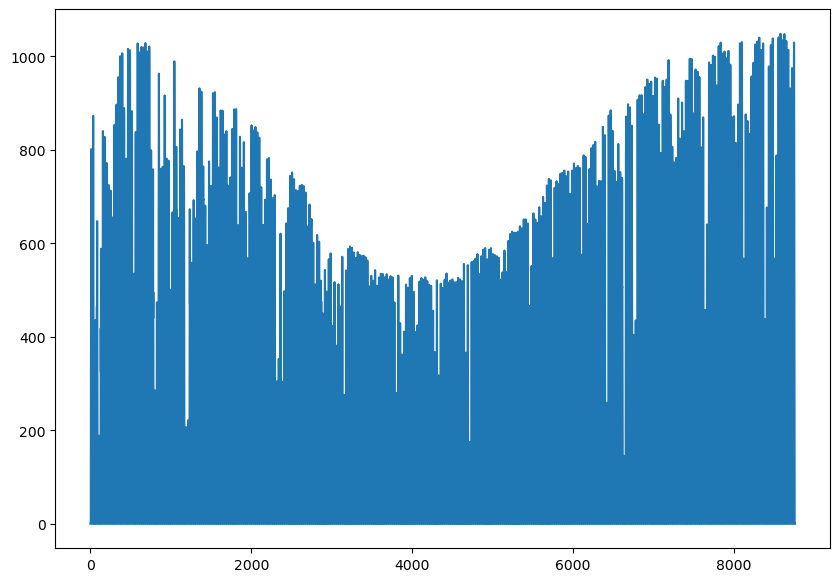

In [26]:
plt.plot(dn)

In [ ]:
pysam_result = pd.read_csv('pysam_profiles_1H.csv')['Greefspan1']
pysam_result.loc[range(0,8761)].mean()

In [ ]:
my_data = cutout.data.sel(x=cutout.grid.loc[closest_point,'x'], 
                y=cutout.grid.loc[closest_point,'y'], 
                method='nearest')

In [ ]:
(my_data['height'].values)

In [ ]:
plt.plot(my_data['influx_direct'].values)

# Comparison of PySAM with ATLITE for REDZ1 and REDZ2

In [ ]:
# shapefile_dict = {
#     'redz_1': '../data/bundle/Phase1_REDZs/REDZs.shp',
#     'redz_2': '../data/bundle/Phase2_REDZs/PHASE 2_REDZs.shp',
#     #'power_corridor': '../data/bundle/Power_corridors/Power_corridors.shp',
#     #'11_supply': '../data/bundle/supply_regions/11-supply.shp',
#     #'30_supply': '../data/bundle/supply_regions/30-supply.shp'
# }

# all_geometry_results = process_all_shapefiles(cutout, shapefile_dict)

# for geometry_name, data_array in all_geometry_results.items():
#     filename = f"{geometry_name}.nc"
#     data_array.to_netcdf(filename)

nc_files = [
'redz_1_Stormberg Wind',
'redz_1_Komsberg Wind',
'redz_1_Cookhouse Wind',
'redz_1_Springbok Wind',
'redz_1_Kimberley Solar',
'redz_1_Overberg Wind',
'redz_1_Vryburg Solar',
'redz_1_Upington Solar',
'redz_2_Beaufort West',
'redz_2_Emalahleni',
'redz_2_Klerksdorp']

capacity_factors = {}
rated_power_capacity = 1000 # AC nameplate capacity 1kW converted to W
for file in nc_files:
    with xr.open_dataset(file + '.nc') as data:
        capacity_factor = data.sum(dim='time')/(rated_power_capacity*8760)
        geometry_name = file.split('_')[2]
        capacity_factors[geometry_name] = capacity_factor

capacities_redz = pd.DataFrame(index=capacity_factors.keys(), columns=['cap_factor'])
for key in capacity_factors.keys():
    #print(f"Processing key: {key}")
    df = capacity_factors[key]
    df = df.to_dataframe().reset_index()
    df_filtered = df[df["__xarray_dataarray_variable__"] != 0]
    mean_value = df_filtered["__xarray_dataarray_variable__"].mean()
    capacities_redz.loc[key, 'cap_factor'] = mean_value

mean_values_sat = {}
mean_values_ft = {}

for name in pv_sat.Name.values:
    mean_values_sat[name] = pv_sat.sel(Name=name).values.mean()
    mean_values_ft[name] = pv_ft.sel(Name=name).values.mean()   

mean_values_df_sat = pd.DataFrame(list(mean_values_sat.items()), columns=['redz', 'cap_factor'])
mean_values_df_sat.set_index('redz', inplace=True)

mean_values_df_ft = pd.DataFrame(list(mean_values_ft.items()), columns=['redz', 'cap_factor'])
mean_values_df_ft.set_index('redz', inplace=True)

# Plotting
cm = 1/2.54
defaultFigureWidth = 10.5 * cm
defaultFigureHeight = 11 * cm
fig, ax = plt.subplots(figsize=(defaultFigureWidth, defaultFigureHeight))
bar_width = 0.2
n_groups = len(mean_values_df_ft.index)
index = np.arange(n_groups)
index_shifted = index + bar_width

capacities_redz.plot(kind='bar', ax=ax, width=bar_width, position=0, color='b')
mean_values_df_ft.plot(kind='bar', ax=ax, width=bar_width, position=1, color='r')
mean_values_df_sat.plot(kind='bar', ax=ax, width=bar_width, position=2, color='g')


ax.legend(title='',labels=['PySAM','Atlite-FixedTilt','Atlite-SingleAxisTracking'])
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(mean_values_df_ft.index)
plt.ylim(0,0.45)
ax.set_xlabel('REDZs')
ax.set_ylabel('Capacity Factor - %')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

plt.show()


# Comparison of PySAM with CSIR 27-supply data

In [ ]:
nc_files = [
# 'power_corridor_Western corridor',
# 'power_corridor_Northern corridor',
# 'power_corridor_International corridor',
# 'power_corridor_Eastern corridor',
# 'power_corridor_Central corridor',
'30_supply_Bloemfontein',
'30_supply_Carletonville',
'30_supply_East London',
'30_supply_East Rand',
'30_supply_Empangeni',
'30_supply_Highveld South',
'30_supply_Johannesburg North',
'30_supply_Johannesburg South',
'30_supply_Karoo',
'30_supply_Kimberley',
'30_supply_Ladysmith',
'30_supply_Lephalale',
'30_supply_Lowveld',
'30_supply_Middelburg',
'30_supply_Namaqualand',
'30_supply_Newcastle',
'30_supply_Outeniqua',
'30_supply_Peninsula',
'30_supply_Phalaborwa',
'30_supply_Pinetown',
'30_supply_Polokwane',
'30_supply_Port Elizabeth',
'30_supply_Rustenburg',
'30_supply_Sasolburg',
'30_supply_Tshwane',
'30_supply_Vaal Triangle',
'30_supply_Welkom',
'30_supply_West Coast',
'30_supply_West Rand',
'30_supply_Witbank',
]

capacities_30_supply = pd.DataFrame(index=capacity_factors.keys(), columns=['cap_factor'])
for key in capacity_factors.keys():
    #print(f"Processing key: {key}")
    df = capacity_factors[key]
    df = df.to_dataframe().reset_index()
    df_filtered = df[df["__xarray_dataarray_variable__"] != 0]
    mean_value = df_filtered["__xarray_dataarray_variable__"].mean()
    capacities_30_supply.loc[key, 'cap_factor'] = mean_value
    
capacity_factors = {}
rated_power_capacity = 1000 # DC nameplate capacity 1kW converted to W
for file in nc_files:
    with xr.open_dataset(file + '.nc') as data:
        capacity_factor = data.sum(dim='time')/(rated_power_capacity*8760)
        geometry_name = file.split('_')[2]
        capacity_factors[geometry_name] = capacity_factor


cm = 1/2.54
defaultFigureWidth = 10.5 * cm
defaultFigureHeight = 11 * cm

csir_data = csir_data.resample('H').mean()
csir_data.columns = [x.title() for x in csir_data.columns]          

# Only plot common supply areas
common_areas = csir_data.columns.intersection(capacities_30_supply.index)

csir_data_common = csir_data[common_areas].mean()
capacities_30_supply_common = capacities_30_supply.loc[common_areas, 'cap_factor']
n_groups = len(common_areas)

fig, ax = plt.subplots(figsize=(defaultFigureWidth, defaultFigureHeight))
bar_width = 0.35
index = np.arange(n_groups)
index_shifted = index + bar_width

csir_data_common.plot(kind='bar', ax=ax, width=bar_width, position=1, color='b')
capacities_30_supply_common.plot(kind='bar', ax=ax, width=bar_width, position=0, color='r')

ax.legend(title='',labels=['CSIR','PySAM'])
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(common_areas)
ax.set_xlabel('Supply Area')
ax.set_ylabel('Capacity Factor - %')
plt.ylim(0,0.4)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

plt.show()


In [ ]:
all_geometry_results

{'redz_1': {'redz_1_Stormberg Wind': array([0., 0., 0., ..., 0., 0., 0.]),
  'redz_1_Komsberg Wind': array([0., 0., 0., ..., 0., 0., 0.]),
  'redz_1_Cookhouse Wind': array([0., 0., 0., ..., 0., 0., 0.]),
  'redz_1_Springbok Wind': array([0., 0., 0., ..., 0., 0., 0.]),
  'redz_1_Kimberley Solar': array([0., 0., 0., ..., 0., 0., 0.]),
  'redz_1_Overberg Wind': array([0., 0., 0., ..., 0., 0., 0.]),
  'redz_1_Vryburg Solar': array([0., 0., 0., ..., 0., 0., 0.]),
  'redz_1_Upington Solar': array([0., 0., 0., ..., 0., 0., 0.])},
 'redz_2': {'redz_2_Beaufort West': array([0., 0., 0., ..., 0., 0., 0.]),
  'redz_2_Emalahleni': array([0., 0., 0., ..., 0., 0., 0.]),
  'redz_2_Klerksdorp': array([0., 0., 0., ..., 0., 0., 0.])}}

In [ ]:
nc_files = [
'redz_1_Stormberg Wind',
'redz_1_Komsberg Wind',
'redz_1_Cookhouse Wind',
'redz_1_Springbok Wind',
'redz_1_Kimberley Solar',
'redz_1_Overberg Wind',
'redz_1_Vryburg Solar',
'redz_1_Upington Solar',
'redz_2_Beaufort West',
'redz_2_Emalahleni',
'redz_2_Klerksdorp',
# 'power_corridor_Western corridor',
# 'power_corridor_Northern corridor',
# 'power_corridor_International corridor',
# 'power_corridor_Eastern corridor',
# 'power_corridor_Central corridor',
# '30_supply_Bloemfontein',
# '30_supply_Carletonville',
# '30_supply_East London',
# '30_supply_East Rand',
# '30_supply_Empangeni',
# '30_supply_Highveld South',
# '30_supply_Johannesburg North',
# '30_supply_Johannesburg South',
# '30_supply_Karoo',
# '30_supply_Kimberley',
# '30_supply_Ladysmith',
# '30_supply_Lephalale',
# '30_supply_Lowveld',
# '30_supply_Middelburg',
# '30_supply_Namaqualand',
# '30_supply_Newcastle',
# '30_supply_Outeniqua',
# '30_supply_Peninsula',
# '30_supply_Phalaborwa',
# '30_supply_Pinetown',
# '30_supply_Polokwane',
# '30_supply_Port Elizabeth',
# '30_supply_Rustenburg',
# '30_supply_Sasolburg',
# '30_supply_Tshwane',
# '30_supply_Vaal Triangle',
# '30_supply_Welkom',
# '30_supply_West Coast',
# '30_supply_West Rand',
# '30_supply_Witbank',
]

capacity_factors = {}
rated_power_capacity = 1000 # DC nameplate capacity 1kW converted to W
for file in nc_files:
    with xr.open_dataset(file + '.nc') as data:
        capacity_factor = data.sum(dim='time')/(rated_power_capacity*8760)
        geometry_name = file.split('_')[2]
        capacity_factors[geometry_name] = capacity_factor

# Comparison of PySAM with ATLITE for REDZ1 and REDZ2

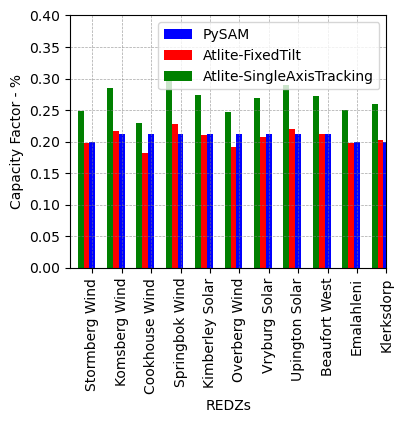

In [ ]:
# shapefile_dict = {
#     'redz_1': '../data/bundle/Phase1_REDZs/REDZs.shp',
#     'redz_2': '../data/bundle/Phase2_REDZs/PHASE 2_REDZs.shp',
#     #'power_corridor': '../data/bundle/Power_corridors/Power_corridors.shp',
#     #'11_supply': '../data/bundle/supply_regions/11-supply.shp',
#     #'30_supply': '../data/bundle/supply_regions/30-supply.shp'
# }

# all_geometry_results = process_all_shapefiles(cutout, shapefile_dict)

# for geometry_name, data_array in all_geometry_results.items():
#     filename = f"{geometry_name}.nc"
#     data_array.to_netcdf(filename)

nc_files = [
'redz_1_Stormberg Wind',
'redz_1_Komsberg Wind',
'redz_1_Cookhouse Wind',
'redz_1_Springbok Wind',
'redz_1_Kimberley Solar',
'redz_1_Overberg Wind',
'redz_1_Vryburg Solar',
'redz_1_Upington Solar',
'redz_2_Beaufort West',
'redz_2_Emalahleni',
'redz_2_Klerksdorp']

capacity_factors = {}
rated_power_capacity = 1000 # AC nameplate capacity 1kW converted to W
for file in nc_files:
    with xr.open_dataset(file + '.nc') as data:
        capacity_factor = data.sum(dim='time')/(rated_power_capacity*8760)
        geometry_name = file.split('_')[2]
        capacity_factors[geometry_name] = capacity_factor

capacities_redz = pd.DataFrame(index=capacity_factors.keys(), columns=['cap_factor'])
for key in capacity_factors.keys():
    #print(f"Processing key: {key}")
    df = capacity_factors[key]
    df = df.to_dataframe().reset_index()
    df_filtered = df[df["__xarray_dataarray_variable__"] != 0]
    mean_value = df_filtered["__xarray_dataarray_variable__"].mean()
    capacities_redz.loc[key, 'cap_factor'] = mean_value

mean_values_sat = {}
mean_values_ft = {}

for name in pv_sat.Name.values:
    mean_values_sat[name] = pv_sat.sel(Name=name).values.mean()
    mean_values_ft[name] = pv_ft.sel(Name=name).values.mean()   

mean_values_df_sat = pd.DataFrame(list(mean_values_sat.items()), columns=['redz', 'cap_factor'])
mean_values_df_sat.set_index('redz', inplace=True)

mean_values_df_ft = pd.DataFrame(list(mean_values_ft.items()), columns=['redz', 'cap_factor'])
mean_values_df_ft.set_index('redz', inplace=True)

# Plotting
cm = 1/2.54
defaultFigureWidth = 10.5 * cm
defaultFigureHeight = 11 * cm
fig, ax = plt.subplots(figsize=(defaultFigureWidth, defaultFigureHeight))
bar_width = 0.2
n_groups = len(mean_values_df_ft.index)
index = np.arange(n_groups)
index_shifted = index + bar_width

capacities_redz.plot(kind='bar', ax=ax, width=bar_width, position=0, color='b')
mean_values_df_ft.plot(kind='bar', ax=ax, width=bar_width, position=1, color='r')
mean_values_df_sat.plot(kind='bar', ax=ax, width=bar_width, position=2, color='g')


ax.legend(title='',labels=['PySAM','Atlite-FixedTilt','Atlite-SingleAxisTracking'])
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(mean_values_df_ft.index)
plt.ylim(0,0.4)
ax.set_xlabel('REDZs')
ax.set_ylabel('Capacity Factor - %')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

plt.show()


# Comparison of PySAM with CSIR 27-supply data

In [ ]:
csir_data = pd.read_excel('../data/bundle/Supply area normalised power feed-in for PV.xlsx', 
                          sheet_name='PV profiles', 
                          index_col=0,
                          skiprows=[1])


IndexError: index 0 is out of bounds for axis 0 with size 0

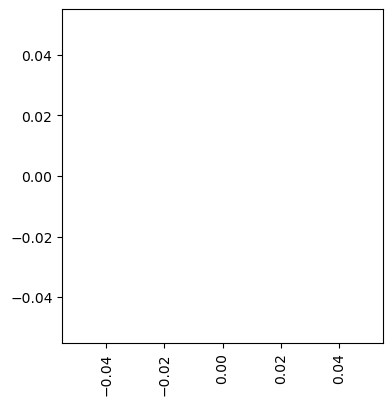

In [ ]:
nc_files = [
# 'power_corridor_Western corridor',
# 'power_corridor_Northern corridor',
# 'power_corridor_International corridor',
# 'power_corridor_Eastern corridor',
# 'power_corridor_Central corridor',
'30_supply_Bloemfontein',
'30_supply_Carletonville',
'30_supply_East London',
'30_supply_East Rand',
'30_supply_Empangeni',
'30_supply_Highveld South',
'30_supply_Johannesburg North',
'30_supply_Johannesburg South',
'30_supply_Karoo',
'30_supply_Kimberley',
'30_supply_Ladysmith',
'30_supply_Lephalale',
'30_supply_Lowveld',
'30_supply_Middelburg',
'30_supply_Namaqualand',
'30_supply_Newcastle',
'30_supply_Outeniqua',
'30_supply_Peninsula',
'30_supply_Phalaborwa',
'30_supply_Pinetown',
'30_supply_Polokwane',
'30_supply_Port Elizabeth',
'30_supply_Rustenburg',
'30_supply_Sasolburg',
'30_supply_Tshwane',
'30_supply_Vaal Triangle',
'30_supply_Welkom',
'30_supply_West Coast',
'30_supply_West Rand',
'30_supply_Witbank',
]

capacities_30_supply = pd.DataFrame(index=capacity_factors.keys(), columns=['cap_factor'])
for key in capacity_factors.keys():
    #print(f"Processing key: {key}")
    df = capacity_factors[key]
    df = df.to_dataframe().reset_index()
    df_filtered = df[df["__xarray_dataarray_variable__"] != 0]
    mean_value = df_filtered["__xarray_dataarray_variable__"].mean()
    capacities_30_supply.loc[key, 'cap_factor'] = mean_value
    
capacity_factors = {}
rated_power_capacity = 1000 # DC nameplate capacity 1kW converted to W
for file in nc_files:
    with xr.open_dataset(file + '.nc') as data:
        capacity_factor = data.sum(dim='time')/(rated_power_capacity*8760)
        geometry_name = file.split('_')[2]
        capacity_factors[geometry_name] = capacity_factor


cm = 1/2.54
defaultFigureWidth = 10.5 * cm
defaultFigureHeight = 11 * cm

csir_data = csir_data.resample('H').mean()
csir_data.columns = [x.title() for x in csir_data.columns]          

# Only plot common supply areas
common_areas = csir_data.columns.intersection(capacities_30_supply.index)

csir_data_common = csir_data[common_areas].mean()
capacities_30_supply_common = capacities_30_supply.loc[common_areas, 'cap_factor']
n_groups = len(common_areas)

fig, ax = plt.subplots(figsize=(defaultFigureWidth, defaultFigureHeight))
bar_width = 0.35
index = np.arange(n_groups)
index_shifted = index + bar_width

csir_data_common.plot(kind='bar', ax=ax, width=bar_width, position=1, color='b')
capacities_30_supply_common.plot(kind='bar', ax=ax, width=bar_width, position=0, color='r')

ax.legend(title='',labels=['CSIR','PySAM'])
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(common_areas)
ax.set_xlabel('Supply Area')
ax.set_ylabel('Capacity Factor - %')
plt.ylim(0,0.4)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

plt.show()


In [ ]:
# cutout = atlite.Cutout(
#     path="../cutouts/RSA-2013-era5.nc",#"../cutouts/RSA-2017_20-era5.nc",
#     chunks={"time": 100},
# )
# cutout.data = cutout.data.sel(time=slice('2013-01-01', '2013-12-31')) #cutout.data.sel(time=slice('2019-01-01', '2019-12-31'))

# pv_sat = cutout.pv(    
#     panel="CSi",
#     shapes=cutout.grid,
#     tracking="horizontal",
#     per_unit=True, 
#     orientation={"slope": 0.0, "azimuth": 0},
#     **resource,
# )

# pv_ft = cutout.pv(    
#     panel="CSi",
#     shapes=cutout.grid,
#     tracking=None,
#     per_unit=True, 
#     orientation="latitude_optimal", # or {"slope": 0.0, "azimuth": 0},
#     **resource,
# )

In [ ]:
# rsa_supply = gpd.read_file('../data/bundle/rsa_supply_regions.gpkg', layer='1-supply')

In [ ]:
# pv_ft.sel(dim_0=1).plot(color='r')
# pv_sat.sel(dim_0=1).plot()

In [ ]:
# import os
# import PySAM.ResourceTools as tools  # MOVE BACK TO FILES FOLDER
# import PySAM.Windpower as wp
# import PySAM.Singleowner as so
# import PySAM.Pvwattsv8 as pv

# # replace with key and email address from https://developer.nrel.gov/signup/
# sam_api_key = '6VaYhZeU4bC1yNMhQ9fzGHjaVjucP6iSQu5MTrhL'
# sam_email = 'peter.klein@meridianeconomics.co.za'

# sam_api_key_NM = 'EGQeUyrDX6B25t4df7U7PuAFZsYb43m7jbl3hbDQ'
# sam_email_NM = 'ndivhuwo.musehane@meridianeconomics.co.za'

# # lon = -105.22
# # lat = 39.75

In [ ]:
# # --- Initialize Solar Resource Fetcher with minimum parameters ---
# # See function documentation for full parameter list
# for cell in cutout.grid.index[0:5]:
#     lon = cutout.grid.loc[cell,'x']
#     lat = cutout.grid.loc[cell,'y']

#     nsrdbfetcher = tools.FetchResourceFiles(
#                     tech='solar',
#                     nrel_api_key=sam_api_key_NM,
#                     nrel_api_email=sam_email_NM)

#     # --- List of (lon, lat) tuples or Shapely points ---
#     lon_lats = [(lon, lat)]
#     nsrdbfetcher.fetch(lon_lats)

#     # --- Get resource data file path ---
#     nsrdb_path_dict = nsrdbfetcher.resource_file_paths_dict
#     nsrdb_fp = nsrdb_path_dict[lon_lats[0]]

In [ ]:
# from dask import delayed, compute

# # Assuming your function extract_solar and cutout object are already defined

# # Create delayed objects for each function call
# tasks = [delayed(extract_solar)(cutout, cell) for cell in cutout.grid.index[0:10]]

# # Compute the results in parallel
# results = compute(*tasks)

# print(results)


In [ ]:
# results